Prompt:

撰寫一段 Python 程式碼，用於遷移學習（Transfer Learning）基於預訓練的 VGG16 模型進行口罩檢測。具體要求如下：

下載數據集：

自動從 GitHub 仓库 Face-Mask-Detection 克隆數據集。
建立遷移學習模型：

使用 TensorFlow/Keras，載入預訓練的 VGG16 模型（不包括頂層）。
添加自定義的全連接層，以進行二分類（戴口罩與未戴口罩）。
凍結 VGG16 的卷積層，僅訓練自定義層。
資料預處理與模型訓練：

使用 ImageDataGenerator 進行資料增強，將數據集分為訓練集與驗證集。
將圖片調整為大小為 224x224，並進行歸一化處理。
訓練模型並輸出訓練過程。
實現圖片分類功能：

寫一個函數 classify_image，可接受圖片 URL，下載圖片並進行預測，返回圖片所屬類別及置信度。
支持實時輸入圖片 URL 並輸出結果。
簡易介面：

提供一個循環輸入的功能，允許用戶不斷輸入圖片 URL，並進行分類。
提供選項輸入 "exit" 來結束程式。
程式碼應使用清晰的結構並包含必要的錯誤處理。

生成的程式碼應符合以下條件：

使用 TensorFlow/Keras 作為框架。
包含完整的數據處理、模型建立、訓練與測試功能。
支援從 GitHub 自動下載數據集。
實現簡易用戶輸入界面進行即時圖片分類。

In [13]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git


fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_file
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import os

# 步驟 0：下載數據集
if not os.path.exists('Face-Mask-Detection'):
    os.system('git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git')

data_dir = 'Face-Mask-Detection/dataset'

# 步驟 1：載入預訓練的 VGG16 模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 凍結預訓練模型的卷積層
for layer in base_model.layers:
    layer.trainable = False

# 添加自訂的全連接層
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(2, activation='softmax')(x)  # 兩個類別

# 建立新模型
model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 步驟 2：使用醫療口罩數據集進行訓練
# 資料預處理
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_dir,  # 確保這個路徑包含訓練數據
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 訓練模型
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

# 步驟 3：允許使用 HTTP 圖片進行分類
def classify_image(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 預測類別
        predictions = model.predict(img_array)
        class_idx = np.argmax(predictions)
        class_label = list(train_data.class_indices.keys())[class_idx]
        return f"預測類別: {class_label}，信心值: {predictions[0][class_idx]:.2f}"
    except Exception as e:
        return f"無法處理圖片: {e}"

# 測試分類功能
def test_image(image_url, model, class_labels):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 預測類別
        predictions = model.predict(img_array)
        class_idx = np.argmax(predictions)
        class_label = class_labels[class_idx]
        print(f"預測類別: {class_label}，信心值: {predictions[0][class_idx]:.2f}")
    except Exception as e:
        print(f"無法處理圖片: {e}")

image_url = input("請輸入圖片 URL: ")
test_image(image_url, model, list(train_data.class_indices.keys()))


Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 35/103 ━━━━━━━━━━━━━━━━━━━━ 29s 434ms/step - accuracy: 0.6668 - loss: 2.4893

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 89s 679ms/step - accuracy: 0.7682 - loss: 1.3738 - val_accuracy: 0.9670 - val_loss: 0.1081
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 109s 515ms/step - accuracy: 0.9330 - loss: 0.1882 - val_accuracy: 0.9511 - val_loss: 0.1358
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 516ms/step - accuracy: 0.9430 - loss: 0.1572 - val_accuracy: 0.9670 - val_loss: 0.0803
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 57s 517ms/step - accuracy: 0.9415 - loss: 0.1498 - val_accuracy: 0.9743 - val_loss: 0.0762
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 92s 631ms/step - accuracy: 0.9495 - loss: 0.1415 - val_accuracy: 0.9682 - val_loss: 0.0799
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 71s 516ms/step - accuracy: 0.9532 - loss: 0.1291 - val_accuracy: 0.9658 - val_loss: 0.0895
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.9511 - loss: 0.1422 - val_accuracy: 0.9804 - val_loss: 0.0533
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 515ms/step - accuracy: 0.9541 - loss: 0.1241 - va

戴口罩的圖片 (with_mask)
1.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0129.png
2.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0323.jpg
3.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0417.jpg
4.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0502.png
5.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0803.jpg
6.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0932.jpg
7.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0999.png
8.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0_0_0%20copy%2010.jpg
9.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0_0_0%20copy%2011.jpg
10.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0_0_0%20copy%2012.jpg



未戴口罩的圖片 (without_mask)
1.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0.jpg
2.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0014.jpg
3.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0029.jpg
4.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0043.jpg
5.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0074.jpg
6.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0084.jpg
7.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0136.jpg
8.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_anhu_0004.jpg
9.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_anhu_0020.jpg
10.	https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_anhu_0025.jpg



In [19]:
# 簡易介面
while True:
    image_url = input("請輸入圖片 URL (或輸入 'exit' 結束): ")
    if image_url.lower() == 'exit':
        print("結束程式。")
        break
    test_image(image_url, model, list(train_data.class_indices.keys()))


請輸入圖片 URL (或輸入 'exit' 結束): https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
預測類別: with_mask，信心值: 0.72
請輸入圖片 URL (或輸入 'exit' 結束): https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_aidai_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
預測類別: without_mask，信心值: 1.00
請輸入圖片 URL (或輸入 'exit' 結束): https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/without_mask/0_0_anhu_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
預測類別: without_mask，信心值: 1.00
請輸入圖片 URL (或輸入 'exit' 結束): https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0_0_0%20copy%2012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
預測類別: with_mask，信心值: 1.00
請輸入圖片 URL (或輸入 'exit' 結束): https://raw.githubusercontent.com/chandrikadeb7/Face-Mask-Detection/master/dataset/with_mask/0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
預測類別: with_mask，信

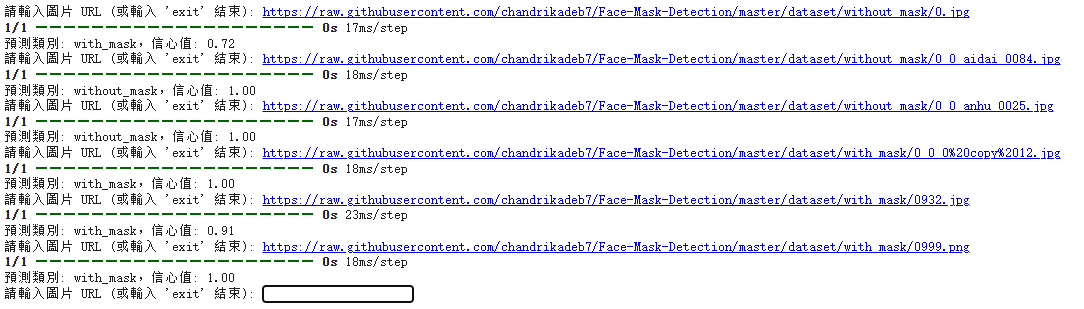